In [27]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [29]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [30]:
# Read weight data
with open('../data/all_weight.pickle', 'rb') as f:
    weights = pd.DataFrame(pickle.load(f))

# Read measure units
with open('../data/all_unit.pickle', 'rb') as f:
    units = pd.DataFrame(pickle.load(f))

# Read user data (need hight for bmi computation)
with open('../data/filtered/users_filter.pickle', 'rb') as f:
    users = pd.DataFrame(pickle.load(f))



In [31]:
#Decode measure units

# select str columns
str_df = units.select_dtypes([np.object])
# convert them all
str_df = str_df.stack().str.decode('utf-8').unstack()
# swap converted with original columns
for col in str_df:
    units[col] = str_df[col]
    
units = units.drop_duplicates()

# Data overview

## Users Data (filtered)

In [32]:
users.head()

,birthday,height,sex,user_id,birthyear
0,1962-01-29 01:00:00,170.0,female,000025b9-60ab-44ec-9589-edd906cbf564,1962
1,1964-11-08 01:00:00,163.0,female,00003941-eab1-4c08-8e57-96612cb7094d,1964
2,1960-04-19 01:00:00,172.0,male,00004dca-f8ca-4536-ad74-46202452e032,1960
3,1967-08-05 01:00:00,187.0,male,0000767c-089c-415f-a3ea-10a83eff7115,1967
4,2000-05-27 02:00:00,172.0,male,0000f27e-7b4e-4cb0-875d-6d067e078291,2000


In [33]:
printmd('**Total number of users:** {}'.format(len(users)))

**Total number of users:** 378472

## Weight data

In [34]:
weights.head()

,bmi,body_weight,measurement_date,user_id
0,28.90080,85.5,2017-01-07 17:37:12,00004dca-f8ca-4536-ad74-46202452e032
1,9.46458,28.0,2017-01-07 18:08:06,00004dca-f8ca-4536-ad74-46202452e032
2,7.06463,20.9,2017-01-07 18:09:18,00004dca-f8ca-4536-ad74-46202452e032
3,27.71770,82.0,2017-01-07 18:10:48,00004dca-f8ca-4536-ad74-46202452e032
4,28.86700,85.4,2017-01-07 18:12:19,00004dca-f8ca-4536-ad74-46202452e032


In [35]:
printmd('**Number of weight entries:** {}'.format(len(weights)))
printmd('**Number of users with at least one weight entry:** {}'.format(
    len(weights['user_id'].unique())))

**Number of weight entries:** 9993364

**Number of users with at least one weight entry:** 183236

## Unit measures

In [36]:
units.head()

,measure_unit,user_id
0,kilos,00004dca-f8ca-4536-ad74-46202452e032
1,kilos,0000767c-089c-415f-a3ea-10a83eff7115
2,kilos,0000f27e-7b4e-4cb0-875d-6d067e078291
3,kilos,000114c3-4880-4128-9eac-19d7f2c6896d
4,kilos,00019ba2-befe-419c-9009-77c8feb4095d


In [37]:
printmd('**Number of unit measure entries:** {}'.format(len(units)))
printmd('**Number of users with at least one unit measure registered:** {}'.format(
    len(units['user_id'].unique())))

**Number of unit measure entries:** 229696

**Number of users with at least one unit measure registered:** 229677

# Data Exploration and Processing

## Filter user unit metrics

In [38]:
# Count measures other than kilos
not_unit_kilos = units.groupby('user_id')['measure_unit'].agg(lambda x: any(x != 'kilos'))
not_unit_kilos = not_unit_kilos[not_unit_kilos==True]
printmd('**Unit metrics found: **{}'.format(
    units['measure_unit'].loc[units.user_id.isin(not_unit_kilos.index)].unique()))
printmd('**Number of users with metrics different from \'kilos\': **{}'.format(
    len(units[units.user_id.isin(not_unit_kilos.index)])))

# Remove metrics other than kilos
printmd('**Remove user with metrics different from \'kilos\'**')

len_before = len(units)
units = units[-units.user_id.isin(not_unit_kilos.index)]
printmd('* Number of entries removed: {}'.format(len_before - len(units)))
printmd('* Number of remaining entries: {}'.format(len(units)))

printmd('**Are there null values in the units table?** {}'.format(
    units.isnull().values.any()))


**Unit metrics found: **['stones' 'kilos' 'pounds']

**Number of users with metrics different from 'kilos': **169

**Remove user with metrics different from 'kilos'**

* Number of entries removed: 169

* Number of remaining entries: 229527

**Are there null values in the units table?** False

## Filter user weights

In [39]:
# Filter weight entries in kilos
printmd('**Remove weight entries not in kilos**')
len_before = len(weights)
weights_filter = weights[weights.user_id.isin(units['user_id'])]
printmd('* Number of weight entries removed: {}'.format(len_before - len(weights_filter)))
printmd('* Number of remaining weight entries: {}'.format(len(weights_filter)))

**Remove weight entries not in kilos**

* Number of weight entries removed: 202736

* Number of remaining weight entries: 9790628

In [40]:
# Filter columns and count entries with null values 
printmd('**Keep only columns of interest: ** [user_id, measurement_date, body_weight, bmi]')
# weights_filter = weights_filter[['user_id', 'updated_date', 'body_weight', 'bmi']]
printmd('* Number of body_weight null values: {}'.format(
    weights_filter['body_weight'].isnull().values.sum()))
printmd('* Number of measurement_date null values: {}'.format(
    weights_filter['measurement_date'].isnull().values.sum()))
printmd('* Number of bmi null values: {}'.format(
    weights_filter['bmi'].isnull().values.sum()))

**Keep only columns of interest: ** [user_id, measurement_date, body_weight, bmi]

* Number of body_weight null values: 0

* Number of measurement_date null values: 0

* Number of bmi null values: 14376

## Statistical profile of weight data

**Original Data:**

* _Max Weight:_ 1000.0

* _Min Weight:_ 0.0

* _Mean Weight:_ 84.19095566386495

* _Standard Deviation:_ 38.686839276739974 

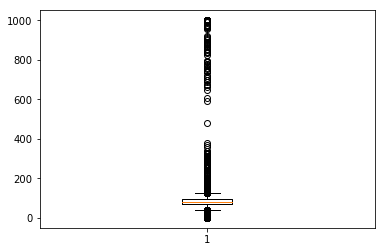

**Remove weight outliers**

* Number of outliers removed: 318430

* Number of remaining weights entries: 9472198

**Filtered Data:**

* _Max Weight:_ 126.3

* _Min Weight:_ 38.3

* _Mean Weight:_ 82.37795206904559

* _Standard Deviation:_ 15.633760682063514 

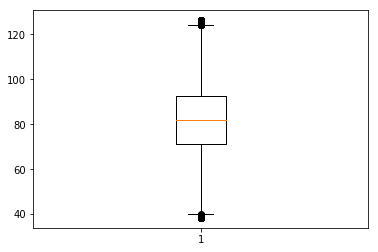

In [41]:
printmd('**Original Data:**')
printmd('* _Max Weight:_ {}'.format(weights_filter['body_weight'].max()))
printmd('* _Min Weight:_ {}'.format(weights_filter['body_weight'].min()))
printmd('* _Mean Weight:_ {}'.format(weights_filter['body_weight'].mean()))
printmd('* _Standard Deviation:_ {} '.format(weights_filter['body_weight'].std()))

box = plt.boxplot(weights_filter['body_weight'], 0)
plt.show()

outliers = box["fliers"][0].get_data()[1]

printmd('**Remove weight outliers**')
len_before = len(weights_filter)
weights_filter = weights_filter[-weights_filter.body_weight.isin(outliers)]
printmd('* Number of outliers removed: {}'.format(len_before - len(weights_filter)))
printmd('* Number of remaining weights entries: {}'.format(len(weights_filter)))

printmd('**Filtered Data:**')
printmd('* _Max Weight:_ {}'.format(weights_filter['body_weight'].max()))
printmd('* _Min Weight:_ {}'.format(weights_filter['body_weight'].min()))
printmd('* _Mean Weight:_ {}'.format(weights_filter['body_weight'].mean()))
printmd('* _Standard Deviation:_ {} '.format(weights_filter['body_weight'].std()))

box = plt.boxplot(weights_filter['body_weight'], 0)
plt.show()


## Handle multiple wieght entries for same user and same timestamp

In [42]:
# Compute standard deviation of multiple wieght entries for same user and same timestamp
measure_date_std = weights_filter.groupby(
        ['user_id', 'measurement_date'])['body_weight'].transform('std')
measure_date_std = measure_date_std.dropna()

**Visualize variation of multiple measures**

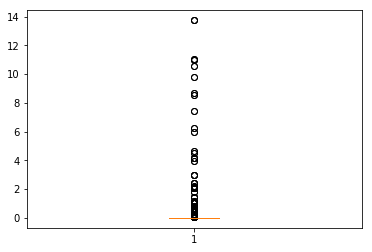

**Sample noisy data**

,bmi,body_weight,measurement_date,user_id
57724,32.1298,101.7,2014-07-31 15:24:01,015c0b66-e460-42ae-bffe-5696e30a711d
57725,32.1298,101.8,2014-07-31 15:24:01,015c0b66-e460-42ae-bffe-5696e30a711d
140157,30.4938,98.7,2014-07-14 09:51:58,0379fb26-ca5d-47a6-a50c-538351acdcde
140158,30.4938,98.8,2014-07-14 09:51:58,0379fb26-ca5d-47a6-a50c-538351acdcde
140165,30.1852,97.7,2014-07-22 13:26:33,0379fb26-ca5d-47a6-a50c-538351acdcde


**Sample non-noisy data**

,bmi,body_weight,measurement_date,user_id
21421,0.0000,82.5,2015-01-07 14:02:59,00923bef-eebf-4c11-8f5a-12bf1f248a35
21422,26.9388,82.5,2015-01-07 14:02:59,00923bef-eebf-4c11-8f5a-12bf1f248a35
21423,32.2266,82.5,2015-01-07 14:02:59,00923bef-eebf-4c11-8f5a-12bf1f248a35
30768,34.4877,120.6,2014-12-31 08:20:05,00bc8897-34c5-41bb-b9af-a068fbd40616
30769,34.8595,120.6,2014-12-31 08:20:05,00bc8897-34c5-41bb-b9af-a068fbd40616


**Remove noisy multiple measures**

* Number of noisy measures removed: 1083

* Number of remaining weight measures: 9471115

**Visualize variation of multiple measures after noise filtering**

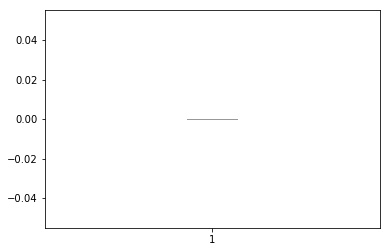

**Maximum standard deviation admited in multiple measures:** 0.0

In [43]:
printmd('**Visualize variation of multiple measures**')
box = plt.boxplot(list(measure_date_std), 0)
plt.show()
outliers = box["fliers"][0].get_data()[1]

printmd('**Sample noisy data**')
di.display(weights_filter.loc[
    measure_date_std[measure_date_std.isin(outliers)].index].head())

printmd('**Sample non-noisy data**')
di.display(weights_filter.loc[
    measure_date_std[-measure_date_std.isin(outliers)].index].head())

printmd('**Remove noisy multiple measures**')
len_before = len(weights_filter)

weights_filter = weights_filter.drop(
    measure_date_std[measure_date_std.isin(outliers)].index)

printmd('* Number of noisy measures removed: {}'.format(
    len_before - len(weights_filter)))
printmd('* Number of remaining weight measures: {}'.format(len(weights_filter)))

printmd('**Visualize variation of multiple measures after noise filtering**')
measure_date_std = weights_filter.groupby(
        ['user_id', 'measurement_date'])['body_weight'].transform('std')
measure_date_std = measure_date_std.dropna()
box = plt.boxplot(list(measure_date_std), 0)
plt.show()

printmd('**Maximum standard deviation admited in multiple measures:** {}'.format(
    max(list(measure_date_std))))


In [44]:
printmd('* Number of remaining weight measures: {}'.format(len(weights_filter)))

* Number of remaining weight measures: 9471115

In [45]:
printmd('***take the average of multiple measures***')
weights_filter['body_weight'] = weights_filter.groupby(
        ['user_id', 'measurement_date'])['body_weight'].transform('mean')
printmd('* Number of duplicated entries after averagind multiple measures: {}'.format(
 weights_filter.duplicated().sum()))

***take the average of multiple measures***

* Number of duplicated entries after averagind multiple measures: 175

## Compute bmi

In [46]:
# Recompute bmi (this will also fill nulls)

# Keep only entries where user data is available
printmd('**Remove weights entry if corresponding user data is not available**')
len_before = len(weights_filter)
weights_filter = weights_filter[
    weights_filter.user_id.isin(users.user_id)]
printmd('* Number of entries removed: {}'.format(len_before - len(weights_filter)))


# Get height for users tables
weights_filter = weights_filter.merge(users[['user_id', 'height']], on='user_id')

# Compute bmi
printmd('**Compute bmi**')
weights_filter['bmi'] = weights_filter['body_weight']/pow(
    (weights_filter['height']/100),2)

# Check there are no null values for bmi
printmd('* Number of null bmi values: {}'.format(
    weights_filter['bmi'].isnull().values.sum()))
        
printmd('**Number of duplicated weight entries:** {}'.format(
    weights_filter.duplicated().sum()))

# Drop duplicates (introduced when taking mean value per user, timestamp)
printmd('**Remove duplicated entries**')
len_before = len(weights_filter)
weights_filter = weights_filter.drop_duplicates()
printmd('* Number of entries removed: {}'.format(len_before-len(weights_filter)))
printmd('* Number of remaining entries: {}'.format(len(weights_filter)))

**Remove weights entry if corresponding user data is not available**

* Number of entries removed: 384502

**Compute bmi**

* Number of null bmi values: 0

**Number of duplicated weight entries:** 59806

**Remove duplicated entries**

* Number of entries removed: 59806

* Number of remaining entries: 9084564

## Histograms of processed data

**Body weight**

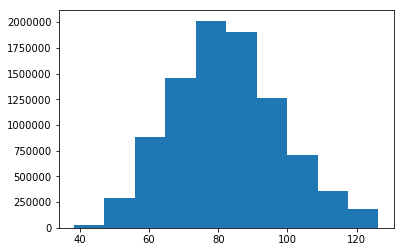

In [47]:
# Weight Histogram
printmd('**Body weight**')
n, bins, patches = plt.hist(
    list(weights_filter['body_weight'].values), bins = 10)
plt.show()

**Bmi**

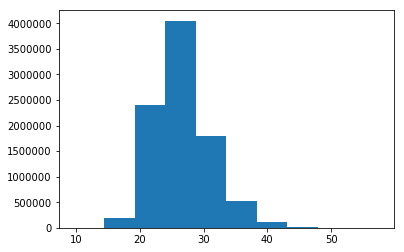

In [48]:
# Bmi Histogram
printmd('**Bmi**')
n, bins, patches = plt.hist(
    list(weights_filter['bmi'].values), bins = 10)
plt.show()

**Number of weight entried per user**

* _Max number of entries_: 3708

* _Min number of entries_: 1

* _Median number of entries_: 18.0

* _Mean number of entries_: 54.60261095350291

* _Standard deviation_: 119.55992509537995

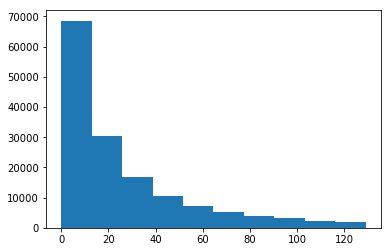

In [49]:
# Number of weight entries per user
printmd('**Number of weight entried per user**')
user_weights = weights_filter.groupby('user_id').apply(lambda g: len(g))
printmd('* _Max number of entries_: {}'.format(max(user_weights)))
printmd('* _Min number of entries_: {}'.format(min(user_weights)))
printmd('* _Median number of entries_: {}'.format(user_weights.median()))
printmd('* _Mean number of entries_: {}'.format(user_weights.mean()))
printmd('* _Standard deviation_: {}'.format(user_weights.std()))
quant = user_weights.quantile(0.9)
n, bins, patches = plt.hist(
    user_weights, bins = 10, range=(0,quant))
plt.show()


In [50]:
with open('../data/filtered/weights_filter.pickle', 'wb') as f:
    pickle.dump(weights_filter, f)